# MNIST 手寫數字辨識
使用 Keras API 來進行手寫數字辨識

### 訓練模型的五步驟：
1. **資料前處理**
    - 讀入資料，檢視資料集格式和狀態
    - 資料整理及前處理
2. **選擇模型**
    - 模型選擇、建制
3. **訓練**
    - 模型訓練和驗證
    - 不斷嘗試、調整模型
4. **測試**
    - 了解模型的性質、檢測信度及效度
5. **執行**
    - 模型上線實際使用

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

2023-05-29 15:46:23.869255: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Step1. 資料前處理

- 讀入資料，檢視資料集格式和狀態
- 資料整理及前處理

In [2]:
# 從 keras 直接讀取 MNIST 資料集
mnist = keras.datasets.mnist
(train_images_all, train_labels_all), (test_images, test_labels) = mnist.load_data()



In [3]:
"""
記得要用「形狀」的方式來理解矩陣。`train_images_all` 矩陣的形狀是 (60000, 28, 28)，每一個維度所提供的資訊分別為 (N, H, W)，其中：

N: 代表 `train_images_all` 中有 N 張照片
H: 代表每張照片的高度為 H 像素
W: 代表每張照片的寬度為 W 像素

如果是彩色照片，則會有第四個維度，代表顏色通道的資訊。所以我們讀進來的照片是灰階的。
"""

print(train_images_all.shape)

(60000, 28, 28)


In [4]:
"""
`train_labels_all` 矩陣的形狀是 (60000,)，這代表 `train_labels_all` 中有 60000 個元素，每個元素都是一個數字，代表該筆資料的標籤。
"""

print(train_labels_all.shape)

(60000,)


In [5]:
"""
印出 `train_images_all` 中第 0 張照片的最大和最小值，可以發現最大值是 255，最小值是 0，
代表每張照片的格式為 unsigned integer 8-bit (uint8)，一個像素能存放 2^8 個資訊。
"""

print(np.max(train_images_all[0]))
print(np.min(train_images_all[0]))

255
0


In [6]:
"""
進行資料前處理，讓每個像素的值介於 0 到 1 之間。
這個步驟叫做標準化 (normalization)，可以讓訓練過程更加順利。
"""
train_images_all = train_images_all / 255.0
test_images = test_images / 255.0

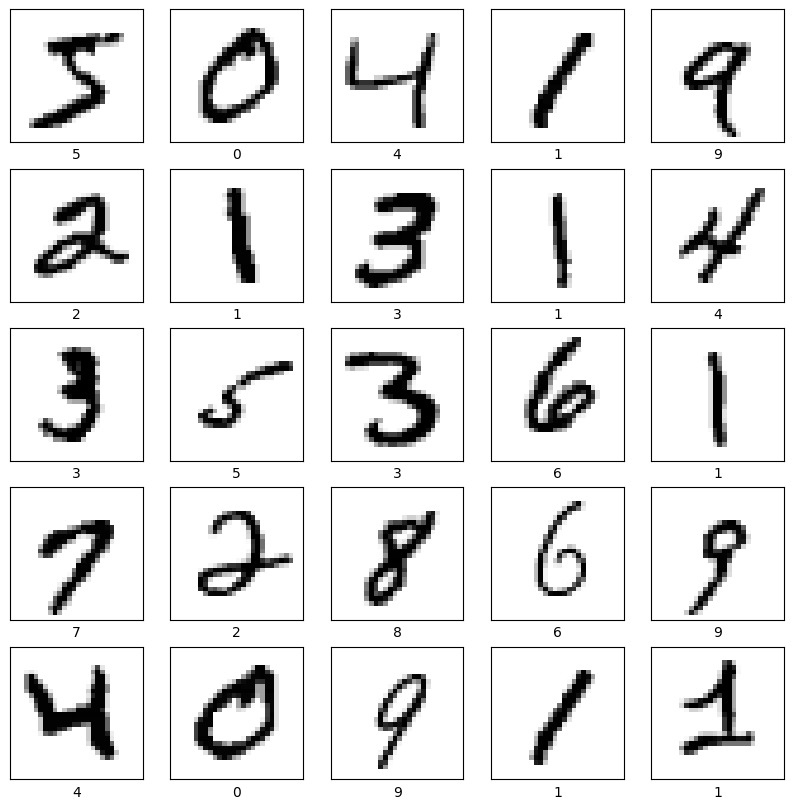

In [7]:
# Plot the first 25 images

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_images_all[i], cmap=plt.cm.binary)
    plt.xlabel(train_labels_all[i])
plt.show()

In [8]:
"""
分出 `train_images` 和 `valid_images` 兩個部分，分別用來訓練模型和驗證模型。
"""

train_images, valid_images = train_images_all[:50000], train_images_all[50000:]
train_labels, valid_labels = train_labels_all[:50000], train_labels_all[50000:]

In [9]:
# one-hot encoding
train_labels = keras.utils.to_categorical(train_labels)
valid_labels = keras.utils.to_categorical(valid_labels)

print(train_labels.shape) # Should be (50000, 10)
print(valid_labels.shape) # Should be (10000, 10)

(50000, 10)
(10000, 10)


In [10]:
print(train_images.shape) # Should be (50000, 28, 28)
print(valid_images.shape) # Should be (10000, 28, 28)

(50000, 28, 28)
(10000, 28, 28)


## Step2. 選擇模型
- 模型選擇、建制

In [11]:
# Build the model
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),     # 將 28x28 的矩陣攤平成 784 的向量
    keras.layers.Dense(1000, activation='relu'),     # 全連接層，128 個神經元，激活函數為 relu
    keras.layers.Dropout(0.5),                      # Dropout 層，隨機斷開 50% 的神經元連接，防止 overfitting
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')    # 輸出層，10 個神經元，激活函數為 softmax，得到預測的機率分佈
])

2023-05-29 15:46:28.010350: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
"""
補充：可以更改權重的初始情形，看看對訓練會造成什麼影響
reference: https://keras.io/api/layers/initializers/
"""

# model = keras.Sequential([
#     keras.layers.Flatten(input_shape=(28, 28)),     
#     keras.layers.Dense(128, activation='relu', kernel_initializer='ones'),     
#     keras.layers.Dropout(0.5),                     
#     keras.layers.Dense(128, activation='relu', kernel_initializer='ones'),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(10, activation='softmax', kernel_initializer='ones')    
# ])

'\n補充：可以更改權重的初始情形，看看對訓練會造成什麼影響\nreference: https://keras.io/api/layers/initializers/\n'

## Step3. 訓練
- 模型訓練和驗證
- 不斷嘗試、調整模型

訓練兩步驟：
```python
model.compile()
model.fit()
```

In [13]:
"""
執行 `model.compile` 設定 loss function、optimizer 和 metrics。
同時，該步驟會在後端建立計算圖，準備之後進行訓練。
"""
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

"""
執行 `model.fit` 進行訓練，訓練過程會存在 `history` 變數中。
"""
EPOCHS = 10
BATCHSIZE = 128
history = model.fit(train_images,   # 訓練資料
                    train_labels,   # 訓練資料的標籤
                    epochs=EPOCHS,  # 代數
                    batch_size=BATCHSIZE, # 每批次使用多少資料
                    validation_data=(valid_images, valid_labels) # 驗證資料
                )

Epoch 1/10
391/391 [==============================] - 11s 26ms/step - loss: 0.3597 - accuracy: 0.8881 - val_loss: 0.1244 - val_accuracy: 0.9632
Epoch 2/10
391/391 [==============================] - 10s 26ms/step - loss: 0.1619 - accuracy: 0.9505 - val_loss: 0.0897 - val_accuracy: 0.9724
Epoch 3/10
391/391 [==============================] - 11s 27ms/step - loss: 0.1242 - accuracy: 0.9622 - val_loss: 0.0917 - val_accuracy: 0.9734
Epoch 4/10
391/391 [==============================] - 10s 25ms/step - loss: 0.1072 - accuracy: 0.9677 - val_loss: 0.0725 - val_accuracy: 0.9782
Epoch 5/10
391/391 [==============================] - 7s 19ms/step - loss: 0.0910 - accuracy: 0.9720 - val_loss: 0.0740 - val_accuracy: 0.9782
Epoch 6/10
391/391 [==============================] - 7s 17ms/step - loss: 0.0809 - accuracy: 0.9750 - val_loss: 0.0757 - val_accuracy: 0.9782
Epoch 7/10
391/391 [==============================] - 7s 18ms/step - loss: 0.0737 - accuracy: 0.9770 - val_loss: 0.0694 - val_accuracy: 0.

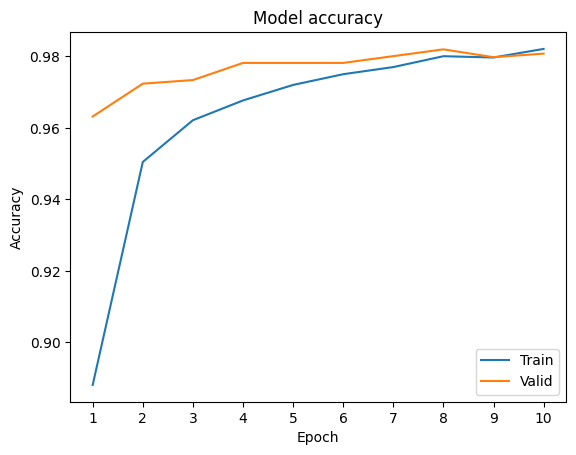

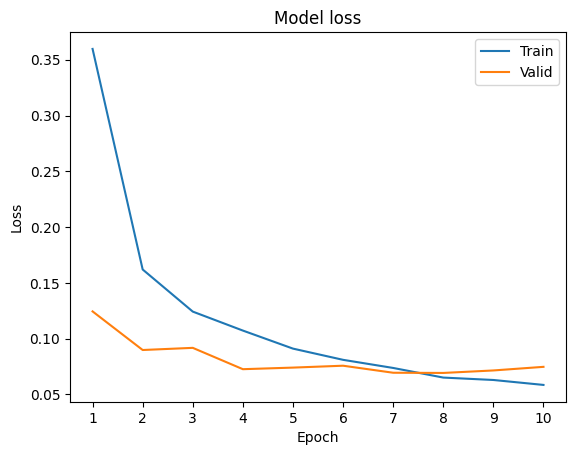

In [14]:
# plot the training and validation accuracy
import matplotlib.pyplot as plt

xticks = np.arange(1, EPOCHS+1, 1)

plt.plot(xticks, model.history.history['accuracy'])
plt.plot(xticks, model.history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(xticks)
plt.legend(['Train', 'Valid'])
plt.show()

plt.plot(xticks, model.history.history['loss'])
plt.plot(xticks, model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(xticks)
plt.legend(['Train', 'Valid'])
plt.show()

## Step5. 測試
- 了解模型的性質、檢測信度及效度

313/313 [==============================] - 1s 4ms/step
The accuracy of your model is: 0.9822


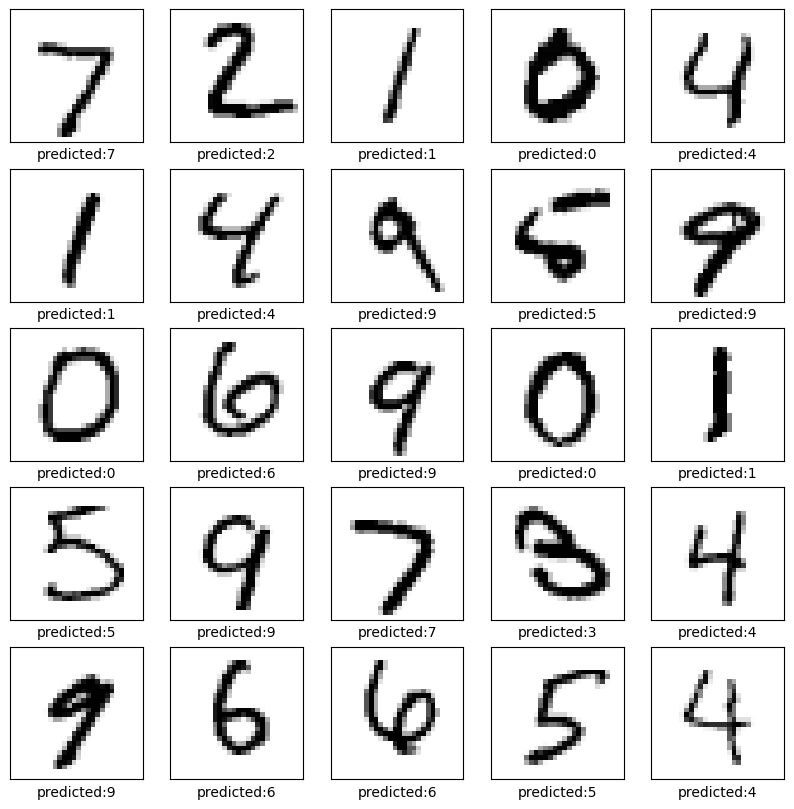

In [16]:
# Make predictions
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
accuracy = np.mean(predicted_labels == test_labels)
print("The accuracy of your model is: {}".format(accuracy))
# Plot the first 25 test images, their predicted labels, and the true labels
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_images[i], cmap=plt.cm.binary)
    plt.xlabel("predicted:{}".format(predicted_labels[i]))
plt.show()

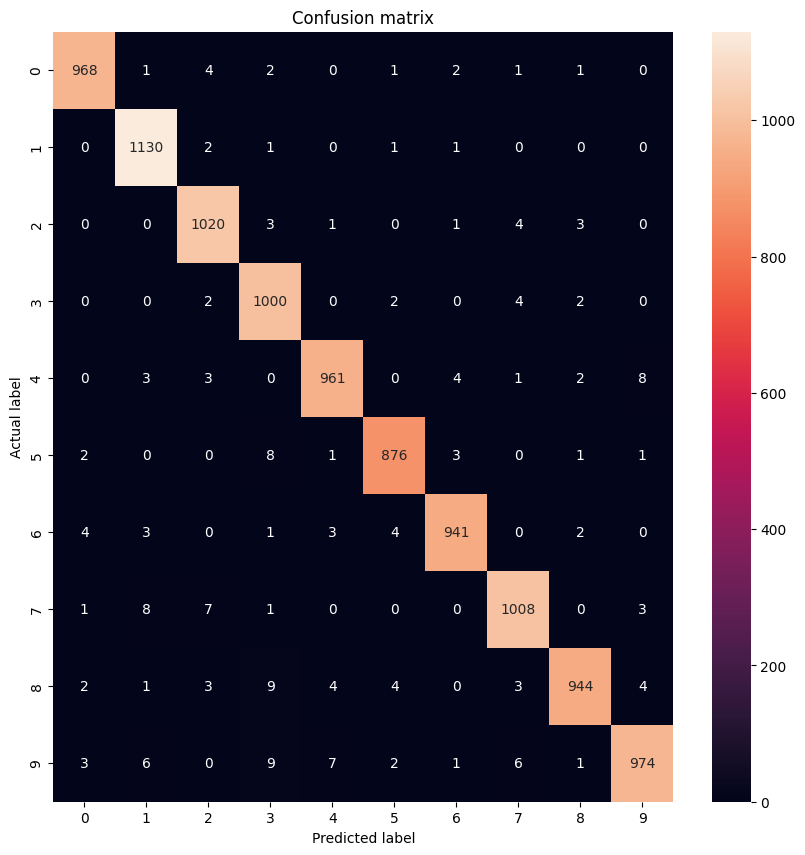

In [17]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

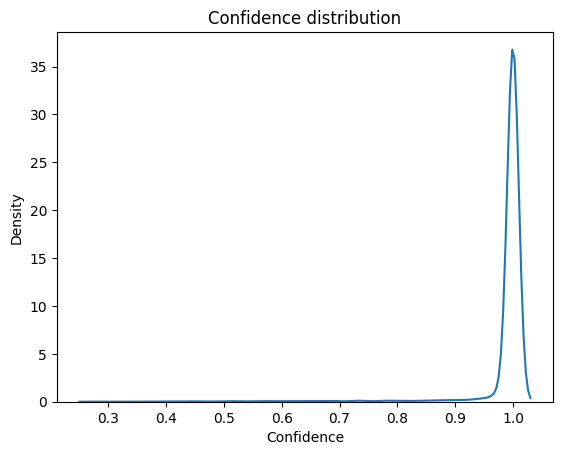

In [18]:
predicted_labels = np.argmax(predictions, axis=1)

# 模型在正確答案上的信心值
confidence = []
for i in range(len(predicted_labels)):
    confidence.append(predictions[i][predicted_labels[i]])

sns.kdeplot(confidence)
plt.title('Confidence distribution')
plt.xlabel('Confidence')
plt.ylabel('Density')
plt.show()

In [20]:
# save the model
model.save('my_mnist_model.h5')

### Step5. 執行
- 模型上線實際使用

In [128]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import _utils

In [164]:
# load the model
model = keras.models.load_model('my_mnist_model.h5')
validcode_path = './validcode'

In [165]:
validcodes_split = _utils.get_data(validcode_path)
validcodes_split.shape # (N, 4, H, W, C)

(5, 4, 24, 31, 3)

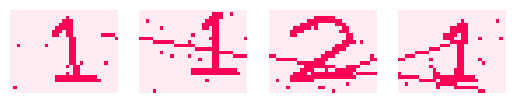

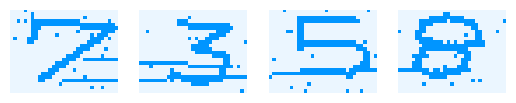

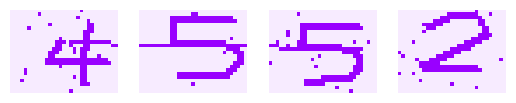

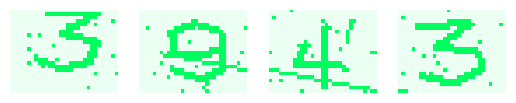

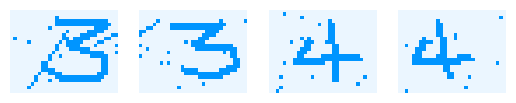

In [166]:
# plot images
N = validcodes_split.shape[0]
for i in range(N):
    for j in range(4):
        plt.subplot(1, 4, j+1)
        plt.imshow(validcodes_split[i][j])
        plt.axis('off')
    plt.show()

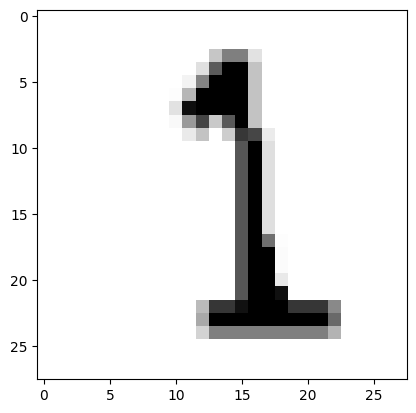

In [167]:
N = validcodes_split.shape[0]
validcodes_proc = np.zeros((N, 4, 28, 28))
for i in range(N):
    for j in range(4):
        validcodes_proc[i, j] = _utils.data_preprocess(validcodes_split[i, j])

validcodes_proc.shape # (N, 4, 28, 28)
plt.imshow(validcodes_proc[0, 0], cmap=plt.cm.binary)

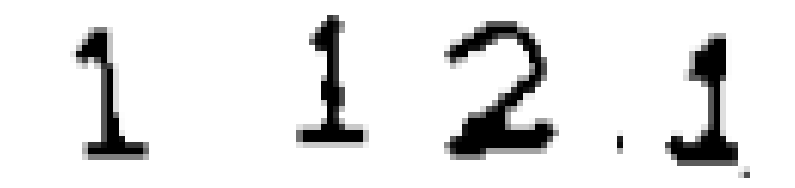

1/1 [==============================] - 0s 51ms/step
Predicted: [2 2 2 3]


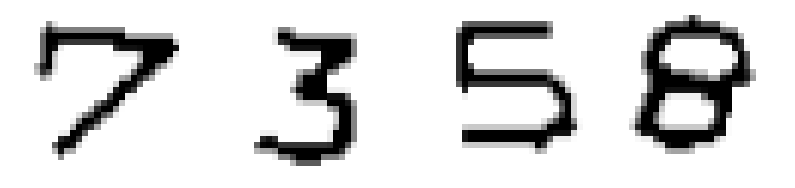

1/1 [==============================] - 0s 20ms/step
Predicted: [3 3 5 3]


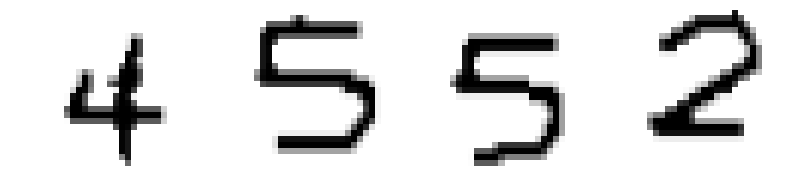

1/1 [==============================] - 0s 21ms/step
Predicted: [4 5 5 2]


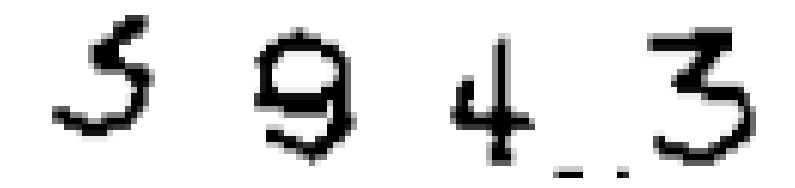

1/1 [==============================] - 0s 22ms/step
Predicted: [6 8 8 3]


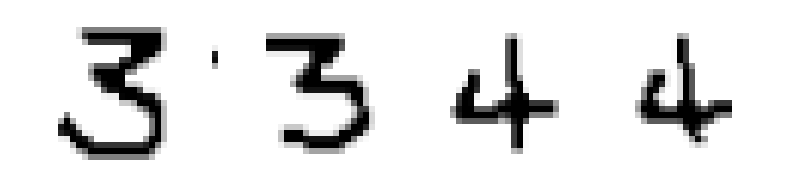

1/1 [==============================] - 0s 24ms/step
Predicted: [2 2 4 2]


In [168]:
# run the model
for i in range(N):
    plt.figure(figsize=(10,10))
    for j in range(4):
        plt.subplot(1, 4, j+1)
        plt.imshow(validcodes_proc[i, j], cmap=plt.cm.binary)
        plt.axis('off')
    plt.show()
    pred = model.predict(validcodes_proc[i])
    pred = np.argmax(pred, axis=1)
    print("Predicted: {}".format(pred))

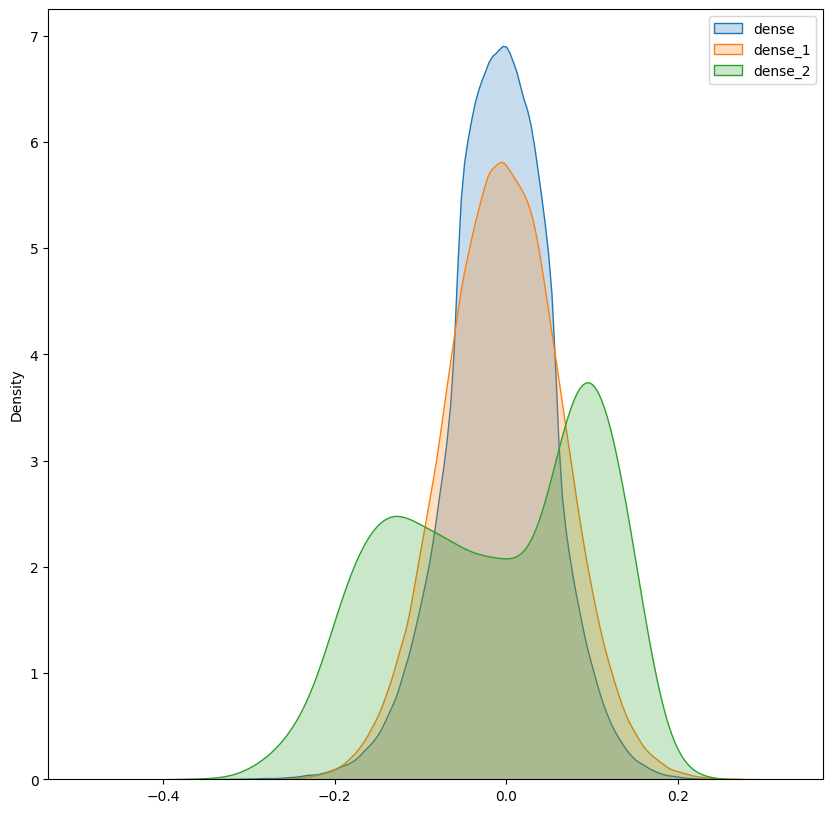

In [19]:
"""
繪製權重的分佈，會發現他們很接近常態分佈！
你也可以試著改變 `kernel_initializer` 的值，無論如何，訓連完成後權重的分佈都會很接近常態分佈。
很神奇吧！
"""

# plot the weights distribution
import seaborn as sns
plt.figure(figsize=(10,10))

for layer in model.layers:
    w = layer.get_weights()
    if len(w) > 0:
        sns.kdeplot(w[0].flatten(), label=layer.name, fill=True)

plt.legend()
plt.show()

# CNN Models
Convolutional neural network (CNN)  is likely to fully connected layer (Dense layer in keras). But has a better performanece for extracting 2D data like images.

Due to fully connected layer will flatten the image strictly and lose the **spatial information**, we shall use another way to keep the spatial information.

In [299]:
"""
CNN 可以保留圖片的空間資訊，並不會像 FCL 一樣將圖片攤平成向量。
先使用 CNN 進行影像特徵的提取，再攤平最後一層 CNN 使用 FCL 進行分類，效果會更好。
"""

model_cnn = keras.Sequential([
    keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape=(28, 28, 1)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(10, activation='softmax')
])

In [300]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model_cnn.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

train_images_cnn = train_images.reshape((50000, 28, 28, 1))
valid_images_cnn = valid_images.reshape((10000, 28, 28, 1))
test_images_cnn = test_images.reshape((10000, 28, 28, 1))

EPOCHS = 10
BATCHSIZE = 128
model_cnn.fit(train_images_cnn, train_labels, epochs=EPOCHS, batch_size=BATCHSIZE, validation_data=(valid_images_cnn, valid_labels))

Epoch 1/10
391/391 [==============================] - 25s 62ms/step - loss: 0.1666 - accuracy: 0.9489 - val_loss: 0.2164 - val_accuracy: 0.9385
Epoch 2/10
391/391 [==============================] - 22s 56ms/step - loss: 0.0490 - accuracy: 0.9854 - val_loss: 0.0429 - val_accuracy: 0.9869
Epoch 3/10
391/391 [==============================] - 22s 56ms/step - loss: 0.0359 - accuracy: 0.9888 - val_loss: 0.0694 - val_accuracy: 0.9793
Epoch 4/10
391/391 [==============================] - 22s 56ms/step - loss: 0.0289 - accuracy: 0.9912 - val_loss: 0.0533 - val_accuracy: 0.9852
Epoch 5/10
391/391 [==============================] - 22s 56ms/step - loss: 0.0225 - accuracy: 0.9930 - val_loss: 0.0378 - val_accuracy: 0.9894
Epoch 6/10
391/391 [==============================] - 22s 56ms/step - loss: 0.0193 - accuracy: 0.9937 - val_loss: 0.0354 - val_accuracy: 0.9903
Epoch 7/10
391/391 [==============================] - 22s 56ms/step - loss: 0.0160 - accuracy: 0.9946 - val_loss: 0.0499 - val_accuracy:

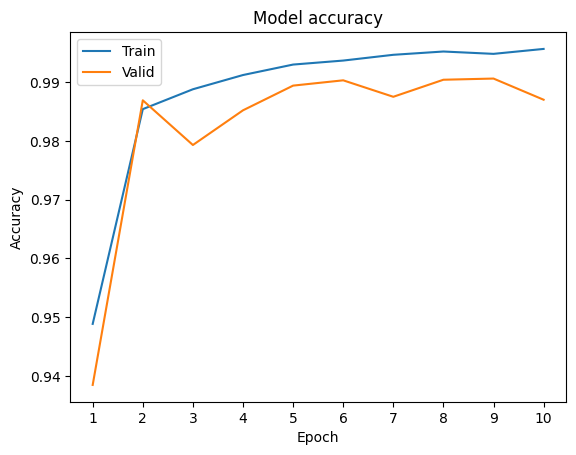

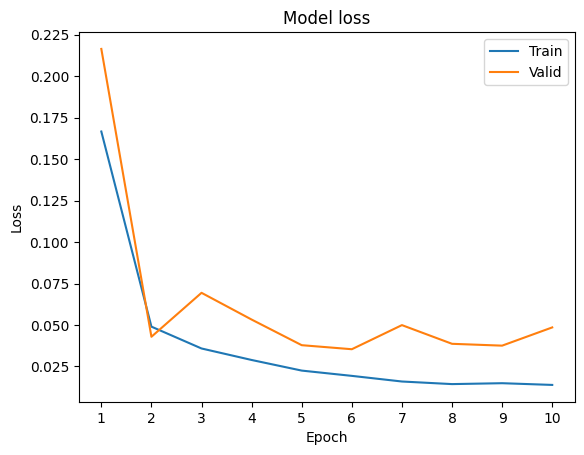

In [301]:
# plot the training and validation accuracy
import matplotlib.pyplot as plt

xticks = np.arange(1, EPOCHS+1, 1)

plt.plot(xticks, model_cnn.history.history['accuracy'])
plt.plot(xticks, model_cnn.history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(xticks)
plt.legend(['Train', 'Valid'])
plt.show()

plt.plot(xticks, model_cnn.history.history['loss'])
plt.plot(xticks, model_cnn.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(xticks)
plt.legend(['Train', 'Valid'])
plt.show()

313/313 [==============================] - 2s 6ms/step
The accuracy of your model is: 0.986


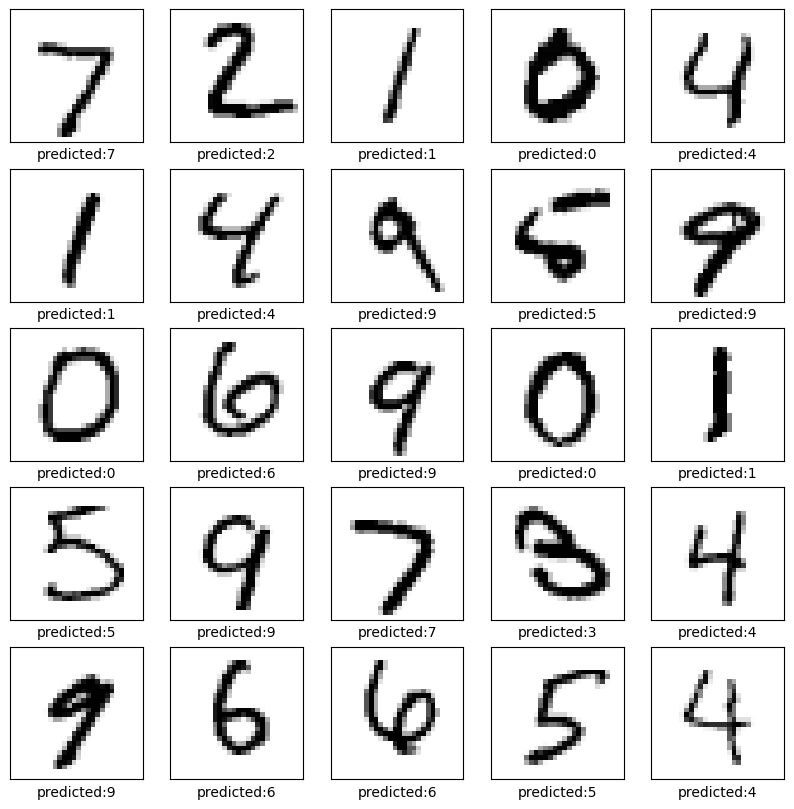

In [302]:
# Make predictions
predictions = model_cnn.predict(test_images_cnn)
predicted_labels = np.argmax(predictions, axis=1)
accuracy = np.mean(predicted_labels == test_labels)
print("The accuracy of your model is: {}".format(accuracy))
# Plot the first 25 test images, their predicted labels, and the true labels
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_images_cnn[i], cmap=plt.cm.binary)
    plt.xlabel("predicted:{}".format(predicted_labels[i]))
plt.show()

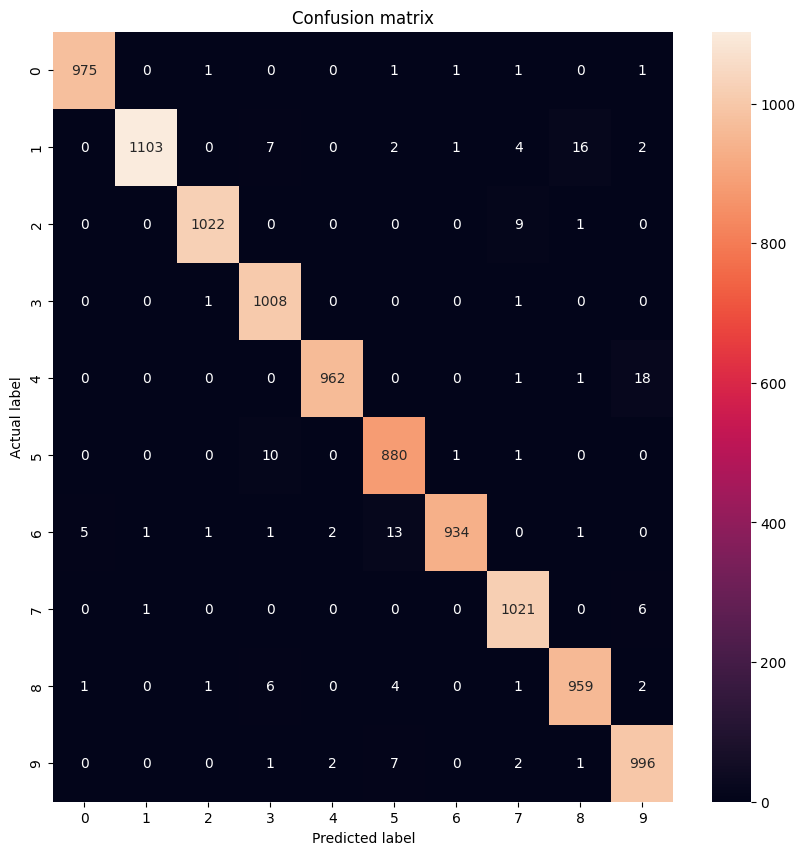

In [303]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## Magic Happens Here!
So, what did the computer learn? Run the code below, you will find the answer of the computer's "vision".

- More **concrete features** are learned in shallower layers. (edge, color, etc.)
- More **abstract features** are learned in deeper layers. (shape, texture, etc.)

Note that if you modified the amount of CNN kernel, don't forget to change the `plt.subplot()` settings.

conv2d_66
(5, 5, 1, 32)


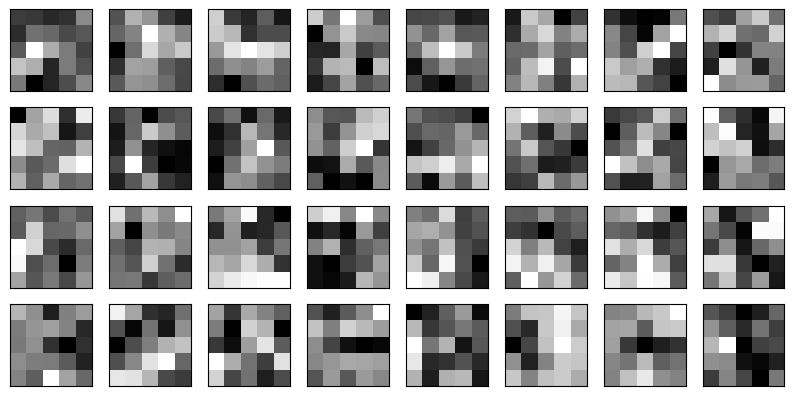

conv2d_67
(3, 3, 32, 64)


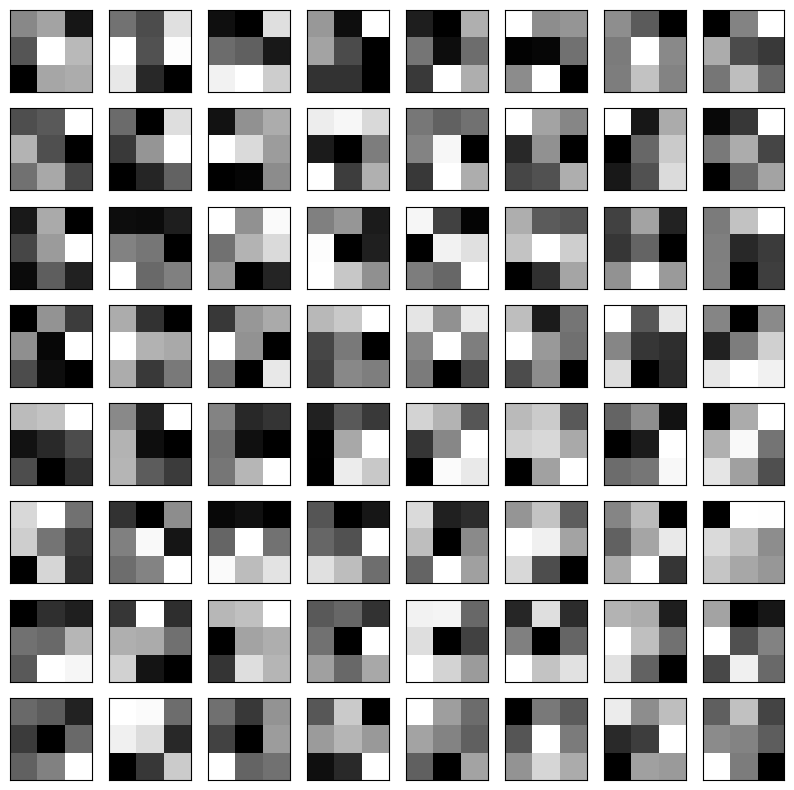

conv2d_68
(3, 3, 64, 64)


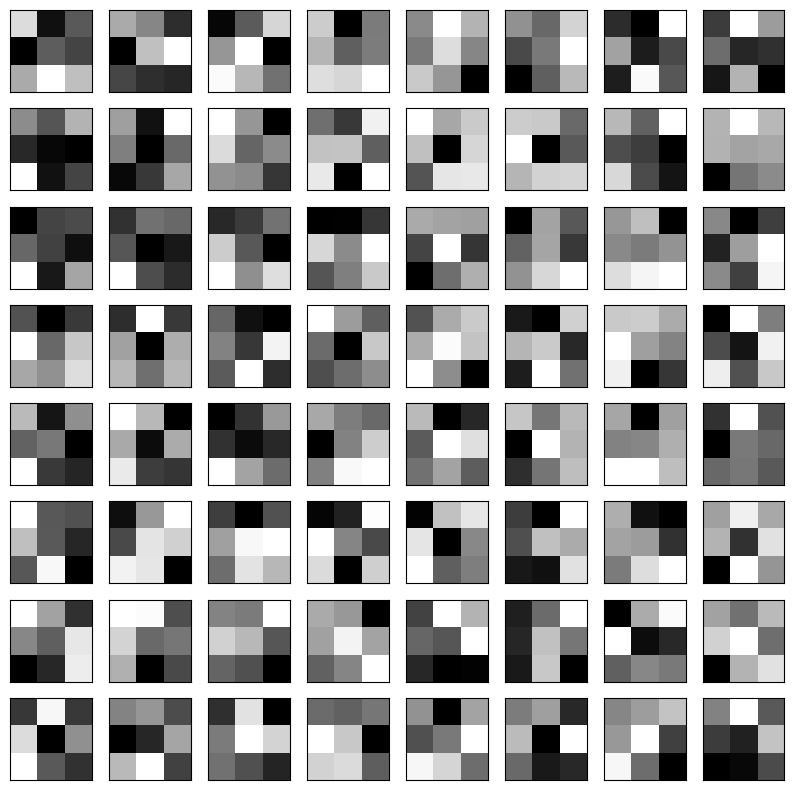

In [304]:
# cnn weights visualization

layers_num = len(model_cnn.layers)

for layer in model_cnn.layers:
    w = layer.get_weights()
    if len(w) > 0 and len(w[0].shape) == 4:
        print(layer.name)
        print(w[0].shape)
        plt.figure(figsize=(10,10))
        for i in range(w[0].shape[3]):
            plt.subplot(8,8,i+1)    # change the number here if you modified the model
            plt.xticks([])
            plt.yticks([])
            plt.imshow(w[0][:,:,0,i], cmap=plt.cm.binary)
        plt.show()


In [305]:
# save the model
model_cnn.save('cnn_model.h5')

### Step5. 執行
- 模型上線實際使用

In [306]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import _utils

In [307]:
# load the model
model = keras.models.load_model('cnn_model.h5')
validcode_path = './validcode'
validcodes_split = _utils.get_data(validcode_path)
validcodes_split.shape # (N, 4, H, W, C)

(5, 4, 24, 31, 3)

(5, 4, 28, 28, 1)


[]

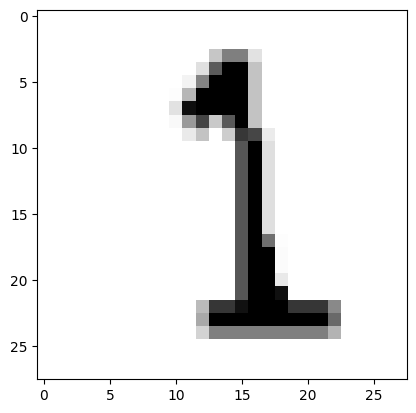

In [308]:
N = validcodes_split.shape[0]
validcodes_proc = np.zeros((N, 4, 28, 28))
for i in range(N):
    for j in range(4):
        validcodes_proc[i, j] = _utils.data_preprocess(validcodes_split[i, j], denoise=True)

validcodes_proc = validcodes_proc.reshape((N, 4, 28, 28, 1))
print(validcodes_proc.shape) # (N, 4, 28, 28, 1)
plt.imshow(validcodes_proc[0, 0], cmap=plt.cm.binary)
plt.plot()

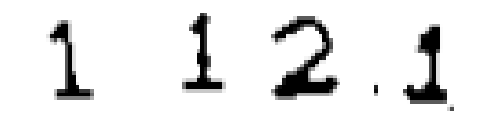

1/1 [==============================] - 0s 85ms/step
Predicted: [1 1 2 1]


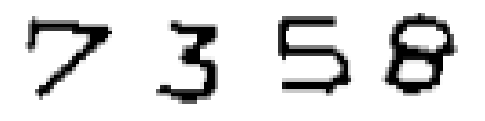

1/1 [==============================] - 0s 21ms/step
Predicted: [7 3 5 0]


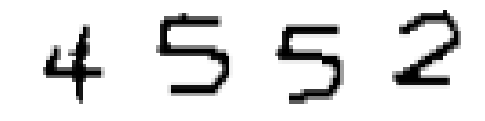

1/1 [==============================] - 0s 19ms/step
Predicted: [4 5 5 2]


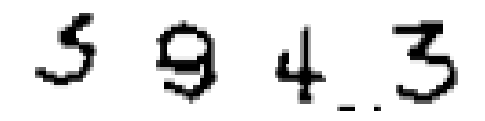

1/1 [==============================] - 0s 18ms/step
Predicted: [7 9 1 3]


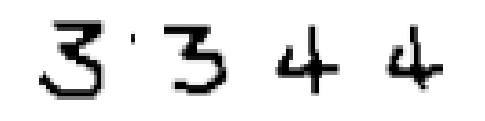

1/1 [==============================] - 0s 18ms/step
Predicted: [5 7 4 6]


In [309]:
# run the model
for i in range(N):
    plt.figure(figsize=(6,6))
    for j in range(4):
        plt.subplot(1, 4, j+1)
        plt.imshow(validcodes_proc[i, j], cmap=plt.cm.binary)
        plt.axis('off')
    plt.show()
    pred = model.predict(validcodes_proc[i])
    pred_num = np.argmax(pred, axis=1)
    print("Predicted: {}".format(pred_num))